In [3]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing

In [20]:
torch.cuda.is_available()

False

In [19]:
omniglot_tr = tv.datasets.Omniglot(root="../omniglot", download=True, background=True)
omniglot_te = tv.datasets.Omniglot(root="../omniglot", download=True, background=False)

Files already downloaded and verified
Files already downloaded and verified


500


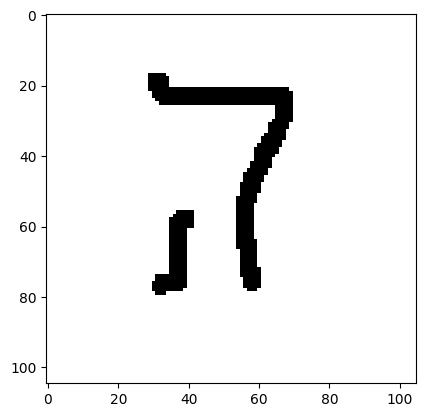

In [37]:
image, label = omniglot_tr[10000]
plt.imshow(image, cmap = 'gray')
print(label)